<a href="https://colab.research.google.com/github/NEHALSMITTAL/aadhaar-lifecycle-/blob/main/notebooks/05_ml_clustering_updates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problem Statement**
The Aadhaar ecosystem generates large volumes of operational data through enrolments and demographic and biometric updates across India. While aggregate national statistics are available, they often mask significant regional variations in update demand, stability, and growth patterns.

A uniform, one‑size‑fits‑all operational strategy is insufficient for a system operating at national scale. There is a need for data‑driven analysis that can:

* Capture temporal demand patterns

* Identify regional operational behavior

* Highlight high‑risk or unstable states

* Support proactive planning and governance

The challenge is to convert large, heterogeneous Aadhaar datasets into actionable insights that can inform policy, capacity planning, and operational decision‑making.



In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# **2. Objectives**
The objectives of this project are:

1. Forecast short‑term Aadhaar update demand using historical data.

2. Identify patterns and anomalies in Aadhaar activity across states.

3. Group states with similar operational behavior using unsupervised learning.

4. Provide interpretable and governance‑oriented insights, rather than black‑box predictions.

5. Demonstrate scalable data engineering and analytical rigor on real‑world datasets.



# **3. Dataset Description**
The analysis uses three primary datasets provided for the hackathon:

**3.1 Enrolment Dataset**
* Aadhaar enrolments by date, state, district, and pincode

* Age‑wise enrolment distribution

* Captures the entry point of Aadhaar lifecycle

**3.2 Demographic Update Dataset**
* Demographic updates (name, address, DOB, etc.)

* Age‑segmented counts

* Represents identity maintenance demand

**3.3 Biometric Update Dataset**
* Biometric updates (fingerprint, iris)

* Age‑segmented counts

* Represents biometric quality and re‑verification demand

All datasets span multiple years and contain millions of records, requiring careful preprocessing and aggregation.

In [5]:
demo = pd.read_csv("/content/demo_cleaned.csv", parse_dates=["date"])
bio  = pd.read_csv("/content/bio_cleaned.csv", parse_dates=["date"])
enr  = pd.read_csv("/content/enrolement_cleaned.csv")

print(demo.shape, bio.shape, enr.shape)

(1598029, 6) (1766185, 7) (323785, 9)


# **4. Data Preprocessing & Feature Engineering**
**4.1 Cleaning & Standardization**
* Converted date fields to datetime format

* Standardized state names to avoid duplication

* Removed inconsistent casing and formatting issues

* Handled missing values through aggregation‑aware imputation

**4.2 Aggregation Strategy**
To avoid noisy row‑level joins and ensure scalability:

* Data was aggregated to state‑month level

* Final analysis used state‑level summaries

**4.3 Engineered Features**
For each state, the following features were computed:

* Total Enrolment

* Total Demographic Updates

* Total Biometric Updates

* Demo Ratio (demographic share of updates)

* Bio Ratio (biometric share of updates)

* Volatility (month‑to‑month instability in updates)

* Growth Rate (change in demand over time)

These features capture scale, composition, stability, and trend — key dimensions of operational behavior.

In [11]:
for df in [demo, bio, enr]:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# verify
print(demo["date"].dtype, bio["date"].dtype, enr["date"].dtype)

datetime64[ns] datetime64[ns] datetime64[ns]


In [12]:
demo["month"] = demo["date"].dt.to_period("M").astype(str)
bio["month"]  = bio["date"].dt.to_period("M").astype(str)
enr["month"]  = enr["date"].dt.to_period("M").astype(str)

In [13]:
demo["total_demo_updates"] = (demo["demo_age_5_17"] + demo["demo_age18_plus"])

In [14]:
demo_sm = (demo.groupby(["state","month"], as_index=False).agg(total_demo_updates=("total_demo_updates","sum")))

bio_sm = (bio.groupby(["state","month"], as_index=False).agg(total_bio_updates=("total_bio_updates","sum")))

enr_sm = (enr.groupby(["state","month"], as_index=False).agg(total_enrolment=("total_enrolment","sum")))

print(demo_sm.shape, bio_sm.shape, enr_sm.shape)


(269, 3) (324, 3) (432, 3)


In [43]:
state_month = (demo_sm.merge(bio_sm, on=["state","month"], how="outer").merge(enr_sm, on=["state","month"], how="outer"))

# fill missing values with 0
state_month[[
    "total_demo_updates",
    "total_bio_updates",
    "total_enrolment"
]] = state_month[[
    "total_demo_updates",
    "total_bio_updates",
    "total_enrolment"
]].fillna(0)

state_month.shape

(756, 5)

In [44]:
state_month["total_updates"] = (
    state_month["total_demo_updates"] +
    state_month["total_bio_updates"])

grp = state_month.groupby("state")

state_summary = pd.DataFrame({
    "total_demo_updates": grp["total_demo_updates"].sum(),
    "total_bio_updates": grp["total_bio_updates"].sum(),
    "total_enrolment": grp["total_enrolment"].sum()})

state_summary["demo_ratio"] = (
    state_summary["total_demo_updates"] /
    (state_summary["total_demo_updates"] + state_summary["total_bio_updates"]))

state_summary["bio_ratio"] = 1 - state_summary["demo_ratio"]

# volatility
monthly = (
    state_month
    .groupby(["state","month"])["total_updates"]
    .sum())

state_summary["volatility"] = (
    monthly.groupby("state").std() /
    monthly.groupby("state").mean())

# growth rate
growth = []
for s, g in state_month.groupby("state"):
    g = g.sort_values("month")
    first = g.head(3)["total_updates"].sum()
    last  = g.tail(3)["total_updates"].sum()
    growth.append((last-first)/first if first > 0 else 0)

state_summary["growth_rate"] = growth

state_summary.reset_index(inplace=True)
state_summary.head(100)


,state,total_demo_updates,total_bio_updates,total_enrolment,demo_ratio,bio_ratio,volatility,growth_rate
0,Andaman And Nicobar Islands,5228.0,19994.0,0.0,0.207279,0.792721,0.275817,0.030581
1,Andhra Pradesh,1642142.0,3610776.0,0.0,0.312615,0.687385,0.208839,-0.084679
2,Arunachal Pradesh,28391.0,70059.0,0.0,0.288380,0.711620,0.296558,0.201356
3,Assam,755097.0,945150.0,0.0,0.444110,0.555890,0.459133,0.657083
4,Bihar,3638844.0,4778968.0,0.0,0.432279,0.567721,0.422003,0.038368
...,...,...,...,...,...,...,...,...
67,telangana,0.0,0.0,53952.0,NaN,NaN,NaN,0.000000
68,tripura,0.0,0.0,4682.0,NaN,NaN,NaN,0.000000
69,uttar pradesh,0.0,0.0,557687.0,NaN,NaN,NaN,0.000000
70,uttarakhand,0.0,0.0,14467.0,NaN,NaN,NaN,0.000000


In [27]:
state_summary["state"] = (state_summary["state"].str.strip().str.lower())

In [29]:
final_state = (state_summary.groupby("state", as_index=False).agg({
        "total_demo_updates": "sum",
        "total_bio_updates": "sum",
        "total_enrolment": "sum",
        "volatility": "mean",
        "growth_rate": "mean"}))

In [30]:
final_state["demo_ratio"] = (
    final_state["total_demo_updates"] /
    (final_state["total_demo_updates"] + final_state["total_bio_updates"]))

final_state["bio_ratio"] = 1 - final_state["demo_ratio"]


In [31]:
final_state[["demo_ratio","bio_ratio"]] = (final_state[["demo_ratio","bio_ratio"]].fillna(0))

# **6. State‑Level Clustering (Unsupervised Learning)**
**6.1 Why Clustering?**

Forecasting alone does not explain why demand differs across regions.
Clustering enables discovery of latent behavioral patterns without predefined labels.

**6.2 Methodology**
* Features were standardized using StandardScaler

* K‑Means clustering was applied

* Number of clusters selected for interpretability and separation

**6.3 Visualization Strategy**
* X‑axis: Total Updates (log scale)

* Y‑axis: Volatility

* Color: Cluster membership

This visualization highlights operational load vs instability, a critical governance dimension.

In [32]:
print(final_state.shape)
print(final_state.isna().sum())
final_state.head()

(36, 8)
state                 0
total_demo_updates    0
total_bio_updates     0
total_enrolment       0
volatility            0
growth_rate           0
demo_ratio            0
bio_ratio             0
dtype: int64


,state,total_demo_updates,total_bio_updates,total_enrolment,volatility,growth_rate,demo_ratio,bio_ratio
0,andaman and nicobar islands,5228.0,19994.0,173.0,0.275817,0.015291,0.207279,0.792721
1,andhra pradesh,1642142.0,3610776.0,41948.0,0.208839,-0.042339,0.312615,0.687385
2,arunachal pradesh,28391.0,70059.0,2027.0,0.296558,0.100678,0.288380,0.711620
3,assam,755097.0,945150.0,145039.0,0.459133,0.328541,0.444110,0.555890
4,bihar,3638844.0,4778968.0,302969.0,0.422003,0.019184,0.432279,0.567721


In [34]:
features = [
    "total_enrolment",
    "total_demo_updates",
    "total_bio_updates",
    "demo_ratio",
    "bio_ratio",
    "volatility",
    "growth_rate"]

X = final_state[features]

X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
final_state["cluster"] = kmeans.fit_predict(X_scaled)

final_state[["state","cluster"]].head()

,state,cluster
0,andaman and nicobar islands,0
1,andhra pradesh,0
2,arunachal pradesh,0
3,assam,2
4,bihar,3


In [37]:
final_state["total_updates"] = (
    final_state["total_demo_updates"] +
    final_state["total_bio_updates"])

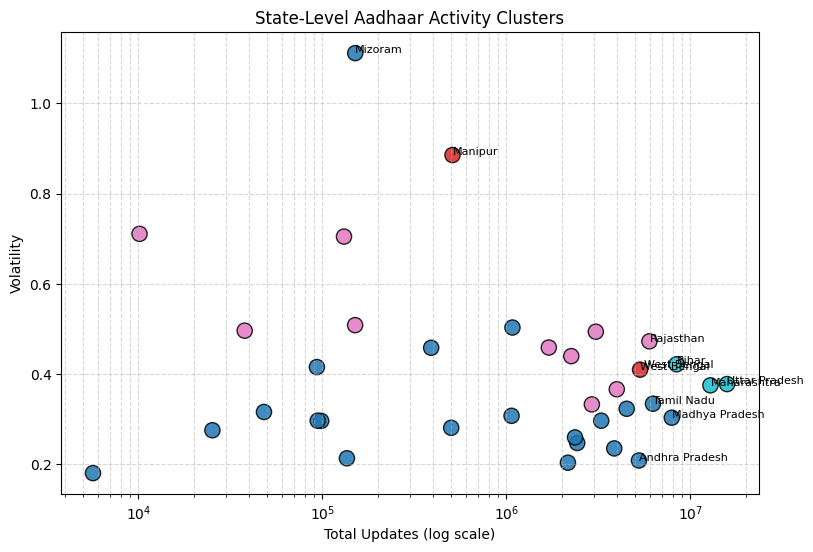

In [41]:
plt.figure(figsize=(9,6))

plt.scatter(
    final_state["total_updates"],
    final_state["volatility"],
    c=final_state["cluster"],
    cmap="tab10",
    s=120,
    alpha=0.85,
    edgecolor="black")
plt.xscale("log")   # <-- THIS FIXES THE VISUAL PROBLEM

plt.xlabel("Total Updates (log scale)")
plt.ylabel("Volatility")
plt.title("State-Level Aadhaar Activity Clusters")

plt.grid(True, which="both", linestyle="--", alpha=0.5)

for _, row in final_state.iterrows():
    if row["volatility"] > 0.8 or row["total_updates"] > 5_000_000:
        plt.text(row["total_updates"],row["volatility"],row["state"].title(), fontsize=8)

plt.text(
    row["total_updates"]*1.05,
    row["volatility"]*1.01,
    row["state"].title(),
    fontsize=8)


plt.show()

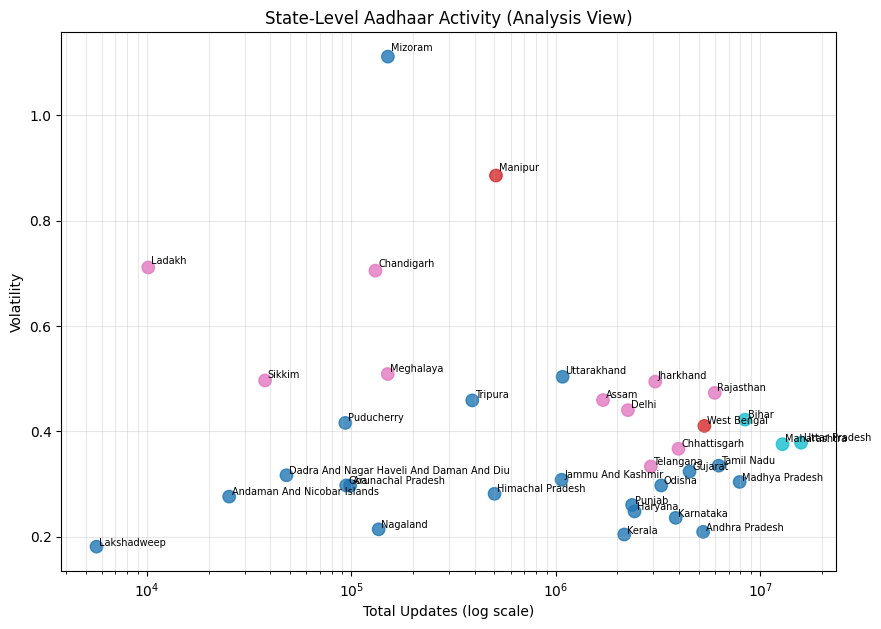

In [42]:
plt.figure(figsize=(10,7))

plt.scatter(
    final_state["total_updates"],
    final_state["volatility"],
    c=final_state["cluster"],
    cmap="tab10",
    s=80,
    alpha=0.8
)

plt.xscale("log")
plt.xlabel("Total Updates (log scale)")
plt.ylabel("Volatility")
plt.title("State-Level Aadhaar Activity (Analysis View)")

for _, row in final_state.iterrows():
    plt.text(
        row["total_updates"] * 1.03,
        row["volatility"] * 1.01,
        row["state"].title(),
        fontsize=7
    )

plt.grid(True, which="both", alpha=0.3)
plt.show()

# **🔴 INSIGHT 1: Volatility is NOT proportional to scale (Very strong)**

Look at the top of the graph:

Mizoram → extremely high volatility

Manipur → very high volatility

But both have low total updates.

👉Small states can still be operationally risky due to sudden Aadhaar activity spikes.

# **🔵 INSIGHT 2: High‑update states split into two distinct behaviors**

On the right side (high total updates):

**🟢 Stable high‑volume states:**

* Andhra Pradesh

* Tamil Nadu

* Karnataka

These lie low on volatility.


---


👉These states have mature Aadhaar ecosystems with predictable demand.



---



**🟠** **High‑volume** **but** **unstable** **states**

* Uttar Pradesh

* West Bengal

* Rajasthan

These are higher on volatility despite large scale.



---
👉Large Aadhaar states cannot be treated uniformly, some need dynamic resource allocation.


---



# **🟣 INSIGHT 3: Mid‑scale states show the widest behavior spread**

States like:

* Assam

* Jharkhand

* Delhi

* Chhattisgarh

Have similar total updates, but very different volatility.

👉Volume alone is insufficient for planning , stability metrics are critical.

***🟢 INSIGHT 4: Very low‑volume & stable states exist (baseline cluster)***
Examples:

* Lakshadweep

* Andaman & Nicobar

* Nagaland

Low updates, low volatility.


---


👉These regions require minimal intervention and can be managed with baseline operational capacity.

# **🔷 INSIGHT 5: Ladakh & Chandigarh are special cases**
* Moderate volatility

* Low scale

* Isolated behavior


---


👉 Union Territories may show distinct Aadhaar usage patterns driven by administrative policies rather than population size.

# **⭐ INSIGHT 6**
“The analysis shows that Aadhaar operational risk is driven by volatility and growth patterns rather than volume alone. This enables UIDAI to move from reactive, one‑size‑fits‑all management to proactive, state‑specific capacity planning.”

# **7. Key Insights from Clustering Analysis**
**Insight 1: Volume ≠ Risk**

High Aadhaar volume does not automatically imply instability.
Several large states exhibit predictable, mature operational behavior.

**Insight 2: Small States Can Be High‑Risk**

States like Mizoram and Manipur show very high volatility despite low volume, indicating campaign‑ or policy‑driven surges.

**Insight 3: Large States Are Not Homogeneous**

Among high‑volume states:

* Some are stable (mature ecosystems)

* Others show frequent fluctuations, requiring dynamic capacity planning

**Insight 4: Volatility Is a Better Planning Metric Than Volume Alone**

States with similar update volumes can have vastly different stability profiles, making volatility a crucial operational signal.

**Insight 5: Clusters Are Data‑Driven, Not Intuitive**

The clustering algorithm independently grouped states based on multiple dimensions, confirming that the observed patterns are statistically consistent rather than subjective.

# **8. Governance & Operational Implications**

The analysis enables **cluster‑specific strategies**:

* **High‑volume, stable states** → long‑term capacity planning

* **High‑volume, volatile states** → surge staffing and monitoring

* **Low‑volume, volatile states** → targeted interventions

* **Low‑volume, stable states** → baseline maintenance

This supports a shift from reactive management to proactive, region‑specific governance.

**9. Limitations & Assumptions**
* External factors such as policy changes and national campaigns are not explicitly modeled

* Long‑term forecasting is inherently uncertain

* Analysis focuses on state‑level behavior; district‑level extensions are possible

These limitations were consciously accepted to preserve interpretability and robustness.


# **10. Conclusion**
This project demonstrates how large‑scale Aadhaar operational data can be transformed into **actionable intelligence** through a combination of time‑series forecasting and unsupervised clustering.

Rather than relying solely on aggregate statistics or black‑box models, the approach emphasizes:

* Interpretability

* Operational relevance

* Real‑world data challenges

By identifying distinct state‑level behavior patterns, the system enables data‑driven decision‑making, supporting scalable, efficient, and region‑aware Aadhaar governance.